# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Git import *

In [3]:
# %run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [14]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_16744\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [16]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [18]:
holding=Binance.get_inventory()

In [19]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2316.82,2198.22,1.00,-131.89,13.28,-118.61,-5.12
BTCUSDT,601.02,1038.35,0.47,3.54,437.32,440.86,19.03
SOLUSDT,281.20,323.78,0.15,0.00,42.58,42.58,1.84
ETHUSDT,250.75,260.19,0.12,0.00,9.44,9.44,0.41
JASMYUSDT,387.46,241.66,0.11,0.00,-145.80,-145.80,-6.29
OMUSDT,526.32,166.39,0.08,0.00,-359.93,-359.93,-15.54
TRXUSDT,76.87,152.27,0.07,-10.72,75.40,64.68,2.79
BBUSDT,60.18,14.30,0.01,-39.73,-45.88,-85.61,-3.70
BNBUSDT,1.14,1.29,0.00,-10.61,0.15,-10.46,-0.45
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [20]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

98

In [21]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [22]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [23]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [24]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [25]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [26]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [28]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: bcd3205f48d0d49f3f09211a276dbd873c6d82f2)
✅ File pushed/updated successfully!


In [29]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [30]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [31]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [32]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: a62df10d0b68d36c3935076e0073c129ef202fbc)
✅ File pushed/updated successfully!


In [33]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [34]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [35]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [36]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [37]:
# pnl_history['Total']

In [38]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [39]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [40]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [41]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [42]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-07-15   -280.678988
2025-07-16   -233.334843
2025-07-17   -208.279235
2025-07-18   -217.204015
2025-07-19    -78.621922
Name: Total, Length: 300, dtype: float64

<Axes: >

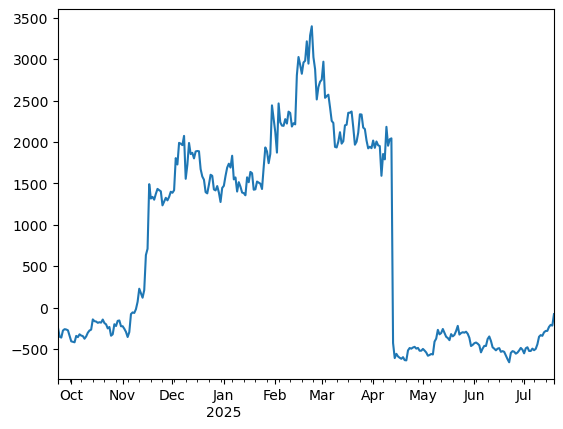

In [43]:
pnl_history['Total'].plot()

In [44]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-07-15      1.309020
2025-07-16     47.344145
2025-07-17     25.055608
2025-07-18     -8.924780
2025-07-19    138.582093
Name: Total, Length: 300, dtype: float64

In [45]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-374.7983250244094, -1142.8435479265506)

In [46]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [47]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [48]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [49]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [50]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [51]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [52]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

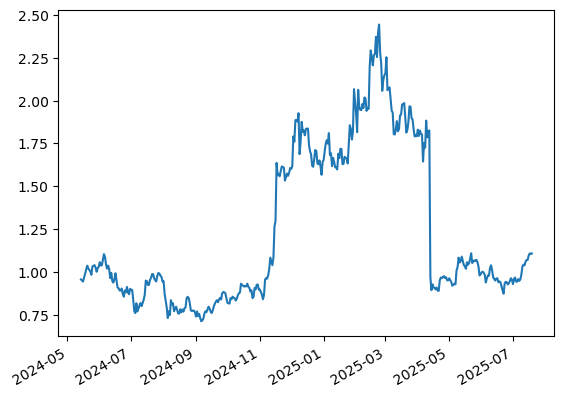

In [53]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

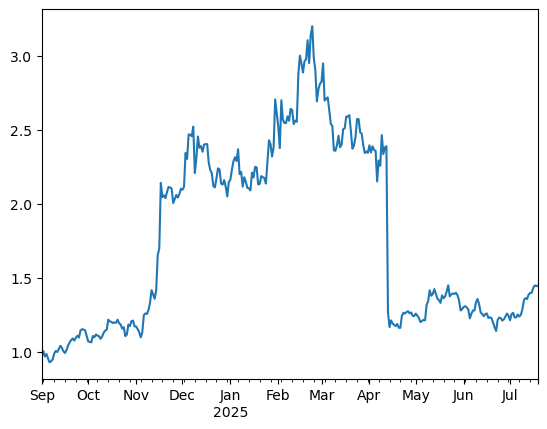

In [54]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [56]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [59]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [60]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [63]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.2845
XRPUSDT,0.1823
TRXUSDT,0.1695
AAVEUSDT,0.1346
OMUSDT,0.0668
WBTCUSDT,0.0663
BTCUSDT,0.0422
PEPEUSDT,0.0412
SUIUSDT,0.0126
WLDUSDT,0.0000


In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
USDCUSDT,0.954371
WBTCUSDT,0.017901
BNBUSDT,0.011700
TRXUSDT,0.007218
XRPUSDT,0.006284
OMUSDT,0.002069
PEPEUSDT,0.000458


In [65]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

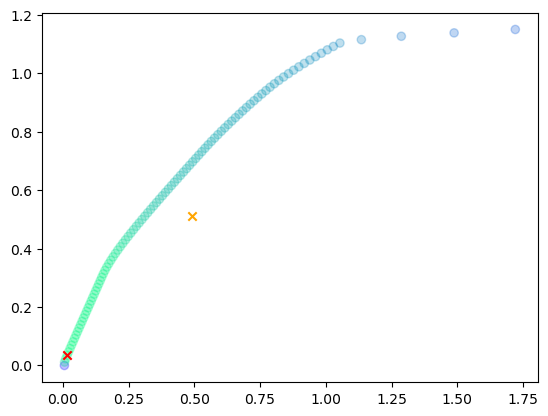

In [66]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [67]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [68]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1038.346249,0.472358,0.0102,0.462158
SOLUSDT,323.783730,0.147294,0.0000,0.147294
ETHUSDT,260.192280,0.118365,0.0000,0.118365
JASMYUSDT,241.657915,0.109934,0.0000,0.109934
OMUSDT,166.385658,0.075691,0.0007,0.074991
TRXUSDT,152.266325,0.069268,0.0027,0.066568
BBUSDT,14.295418,0.006503,0.0000,0.006503
BNBUSDT,1.289859,0.000587,0.0040,-0.003413
PEPEUSDT,0.000003,0.000000,0.0006,-0.000600
PAXGUSDT,0.000000,0.000000,0.0868,-0.086800


### Current results

In [70]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [71]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.685812
TRXUSDT,0.314188


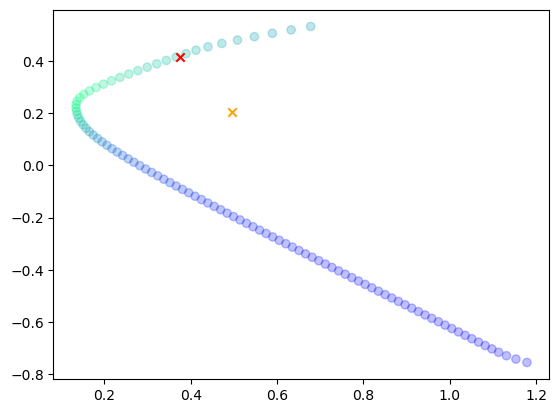

In [72]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [73]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1038.346249,0.472358,0.685812,-0.213454
SOLUSDT,323.783730,0.147294,0.000000,0.147294
ETHUSDT,260.192280,0.118365,0.000000,0.118365
JASMYUSDT,241.657915,0.109934,0.000000,0.109934
OMUSDT,166.385658,0.075691,0.000000,0.075691
TRXUSDT,152.266325,0.069268,0.314188,-0.244920
BBUSDT,14.295418,0.006503,0.000000,0.006503
BNBUSDT,1.289859,0.000587,0.000000,0.000587
PEPEUSDT,0.000003,0.000000,0.000000,0.000000


# Risk Reward Analysis

In [75]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [76]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

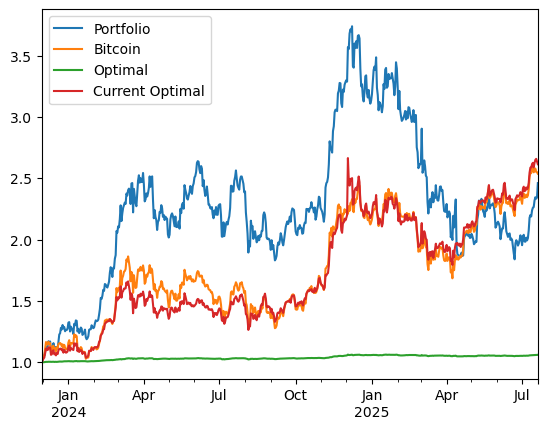

In [77]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [78]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

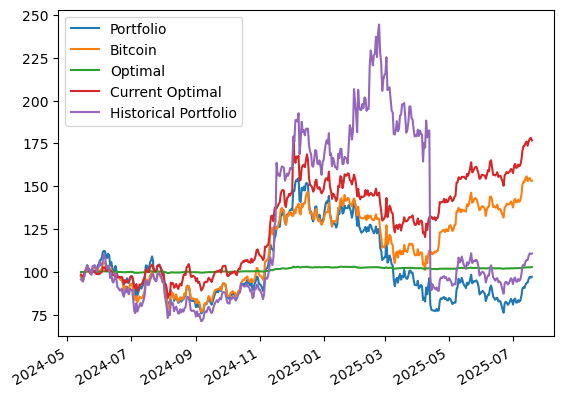

In [79]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [80]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-07-10,90.185967,150.798692,102.461224,170.664657,103.187513
2025-07-11,91.098757,152.758670,102.534874,173.448061,104.252794
2025-07-12,90.611427,152.618673,102.536117,173.573978,103.780180
2025-07-13,92.645784,154.769687,102.590270,175.359889,106.035101
2025-07-14,93.567647,155.747224,102.661013,176.064871,106.911464
2025-07-15,93.788274,153.016207,102.625279,173.580624,107.015321
2025-07-16,95.977264,154.145558,102.682462,176.086259,109.508251
2025-07-17,97.114207,154.854851,102.780289,177.703857,110.825050
2025-07-18,96.628305,153.218498,102.791772,178.243352,110.373211
2025-07-19,97.090230,153.108227,102.797189,176.729162,110.739058


## Volatilities

In [82]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.016575
 dtype: float64,
 0.016589218943583995)

In [83]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.496424
 dtype: float64,
 0.4964241525548136)

In [84]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.493583
Bitcoin            0.413866
Optimal            0.016589
Current Optimal    0.374340
dtype: float64

In [85]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5467757423168855

In [86]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

4.180814301870766

In [87]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.4082979079148819

## Risk Contribution

In [89]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
WBTCUSDT,2.7609,0.3401,0.1957,0.1443
BNBUSDT,1.9156,0.2359,0.0979,0.1381
XRPUSDT,1.4113,0.1834,0.0696,0.1138
TRXUSDT,0.7957,0.1342,0.0674,0.0668
PEPEUSDT,0.0746,0.0197,0.0011,0.0186
USDCUSDT,-0.0517,-0.0080,0.1170,-0.1250
OMUSDT,-2.8944,0.0947,0.0461,0.0487
Portfolio,4.0119,1.0000,0.5948,0.4052


In [90]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,43.373363,0.597623,0.516785,0.080837
TRXUSDT,24.573064,0.402377,0.321540,0.080837
Portfolio,67.946426,1.000000,0.838325,0.161675


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
test=current_risk.perf_contrib(current_weights)

# Value At Risk

## Historical

### Optimal Weights

In [95]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.003522548829818543, -0.003936804863221128)

### Current Weights

In [97]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.0849689154440663, -0.1095599157237281)

In [98]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [99]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.029361
SOLUSDT     -0.018945
ETHUSDT     -0.015827
JASMYUSDT   -0.011616
OMUSDT      -0.007157
TRXUSDT     -0.002194
BBUSDT      -0.001810
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.086911
Name: 2025-04-06 00:00:00, dtype: float64

In [100]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.024111
SOLUSDT     -0.019161
ETHUSDT     -0.012144
JASMYUSDT   -0.013941
OMUSDT      -0.034827
TRXUSDT     -0.003697
BBUSDT      -0.001680
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.109560
dtype: float64

## Parametric

### Optimal Weights

In [103]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.0024310860246017103, -0.0030110590725908404)

### Current Weights

In [105]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.07274904404209535, -0.0901044499736078)

## Multivariate

### Optimal Weights

In [108]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0023216475525697222, -0.00264067068259856)

### Current Weights

In [110]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07154778601812846, -0.08210739978035837)

In [111]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.023227
SOLUSDT     -0.013091
ETHUSDT     -0.009135
JASMYUSDT   -0.013105
OMUSDT      -0.010009
TRXUSDT     -0.002226
BBUSDT      -0.001289
Portfolio   -0.072083
dtype: float64

In [112]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.023105
SOLUSDT     -0.013307
ETHUSDT     -0.009405
JASMYUSDT   -0.012817
OMUSDT      -0.010723
TRXUSDT     -0.002307
BBUSDT      -0.001350
Portfolio   -0.073015
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [116]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0022783731512755587, -0.0026266043931779466)

### Current Weights

In [118]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06949751895170439, -0.08058450318046308)

In [119]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [122]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.002336414955467087, -0.002682004509288241)

### Current Weights

In [124]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07344128597486352, -0.0858674419696721)

In [125]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [128]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.004094920427510967, -0.004942480212163498)

### Current Weights

In [130]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.09702867369898752, -0.11855817111067367)

In [131]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [134]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [135]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0024717654187270356, -0.0028156232477265434)

### Current Weights

In [137]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07520041464947157, -0.08646139551323063)

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [139]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.027876,-0.022576,-0.016892,-0.023227,-0.023867
SOLUSDT,-0.008146,-0.012702,-0.009245,-0.013091,-0.013035
ETHUSDT,-0.002559,-0.008674,-0.006473,-0.009135,-0.008977
JASMYUSDT,-0.010085,-0.013773,-0.009751,-0.013105,-0.013762
OMUSDT,-0.012699,-0.010426,-0.007418,-0.010009,-0.010306
TRXUSDT,-0.001234,-0.002442,-0.002004,-0.002226,-0.002697
BBUSDT,0.000019,-0.001220,-0.000835,-0.001289,-0.001311
Portfolio,-0.062581,-0.071813,-0.052618,-0.072083,-0.073955


In [140]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.026644,-0.022730,-0.017371,-0.023105,-0.024529
SOLUSDT,-0.011250,-0.012540,-0.009768,-0.013307,-0.012918
ETHUSDT,-0.001376,-0.008697,-0.006571,-0.009405,-0.009057
JASMYUSDT,-0.010961,-0.014282,-0.009447,-0.012817,-0.013335
OMUSDT,-0.012375,-0.010737,-0.006882,-0.010723,-0.011356
TRXUSDT,-0.000904,-0.002509,-0.002207,-0.002307,-0.002481
BBUSDT,0.000112,-0.001257,-0.000806,-0.001350,-0.001256
Portfolio,-0.063399,-0.072752,-0.053051,-0.073015,-0.074932


## VaR Violation

In [142]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.001834,-0.002015,-0.001838,-0.000348
2024-01-15,-0.001834,-0.001991,-0.001858,0.000773
2024-01-16,-0.001834,-0.001953,-0.001738,0.000113
2024-01-17,-0.001834,-0.001951,-0.001781,0.000037
2024-01-18,-0.001834,-0.001991,-0.001801,-0.000742
...,...,...,...,...
2025-07-16,-0.001026,-0.001649,-0.001472,0.000557
2025-07-17,-0.001026,-0.001649,-0.001418,0.000953
2025-07-18,-0.001026,-0.001649,-0.001415,0.000112
2025-07-19,-0.001026,-0.001648,-0.001363,0.000053


In [143]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.026218,-0.079580,-0.072131,-0.016581
2024-05-29,-0.019799,-0.077269,-0.068978,-0.009802
2024-05-30,-0.019799,-0.065164,-0.058703,0.026829
2024-05-31,-0.019799,-0.063755,-0.054944,0.008652
2024-06-01,-0.019799,-0.062497,-0.053320,0.020115
...,...,...,...,...
2025-07-16,-0.024822,-0.045251,-0.033698,0.023340
2025-07-17,-0.024822,-0.042436,-0.032689,0.011846
2025-07-18,-0.024822,-0.043366,-0.034257,-0.005003
2025-07-19,-0.010386,-0.036804,-0.026329,0.004780


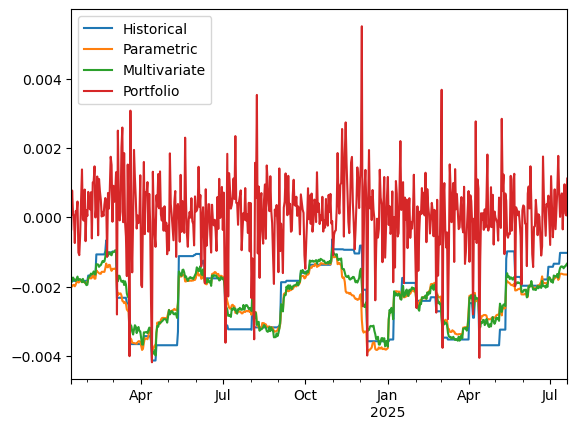

In [144]:
var_data.plot()
plt.show()

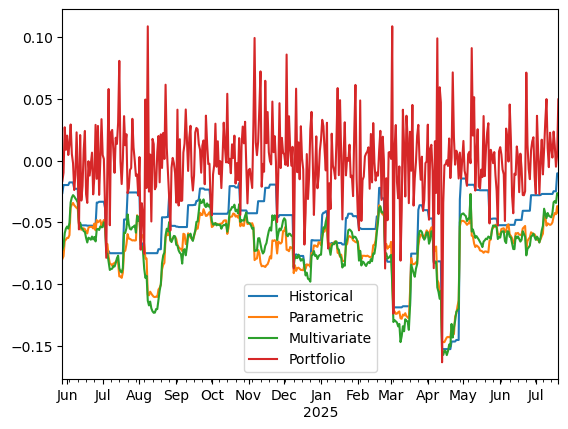

In [145]:
current_var_data.plot()
plt.show()


In [146]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.030686,0.021661,0.028881
Kupiec Stat,5.01663,11.787138,6.095194
P-value,0.025105,0.000596,0.013555


In [147]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.069212,0.02148,0.019093
Kupiec Stat,2.923025,9.046765,10.91366
P-value,0.087324,0.002632,0.000955


# Principal Component Analysis

## Historical PCA

In [150]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77397514, 0.09592463, 0.05498036, 0.03966037, 0.0354595 ])

In [151]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.018142
ADAUSDT      0.018882
ALGOUSDT     0.020281
APTUSDT      0.017997
ARBUSDT      0.020810
ATOMUSDT     0.017264
AVAXUSDT     0.019909
BCHUSDT      0.015026
BNBUSDT      0.008785
BONKUSDT     0.025537
BTCUSDT      0.009792
CFXUSDT      0.023038
CRVUSDT      0.021174
DOGEUSDT     0.019657
DOTUSDT      0.017891
ENSUSDT      0.021446
ETCUSDT      0.016548
ETHUSDT      0.014713
FDUSDUSDT    0.000070
FETUSDT      0.023364
FILUSDT      0.019708
FLOKIUSDT    0.024906
GRTUSDT      0.021964
HBARUSDT     0.019115
ICPUSDT      0.018013
IMXUSDT      0.021181
INJUSDT      0.021865
IOTAUSDT     0.021085
JASMYUSDT    0.022046
LDOUSDT      0.022169
LINKUSDT     0.018345
LTCUSDT      0.013541
MKRUSDT      0.014142
NEARUSDT     0.022111
NEXOUSDT     0.011187
OMUSDT       0.015121
OPUSDT       0.021247
PAXGUSDT     0.000051
PEPEUSDT     0.025757
QNTUSDT      0.015107
SEIUSDT      0.021548
SHIBUSDT     0.018650
SOLUSDT      0.016713
STXUSDT      0.021163
SUIUSDT      0.019067
THETAUSDT 

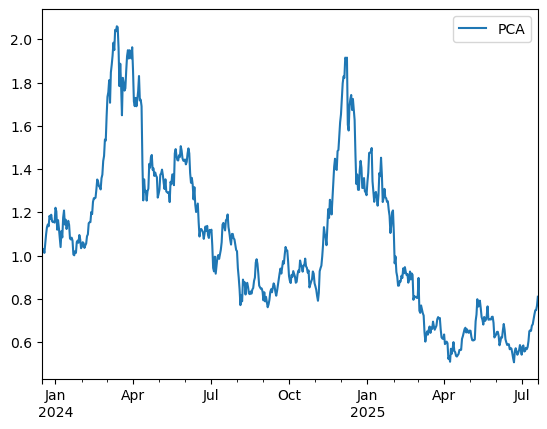

In [152]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

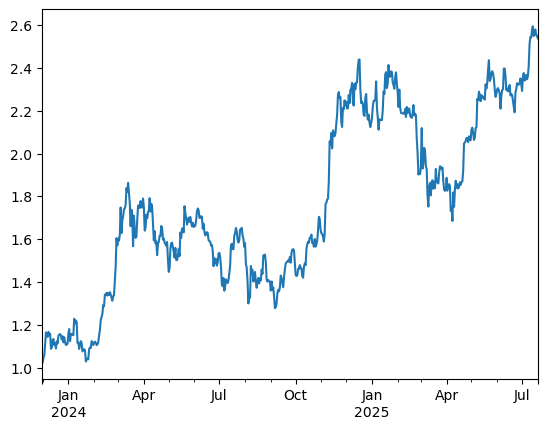

In [153]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [154]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.495856
ETHUSDT      0.496242
DOTUSDT      0.524134
ETCUSDT      0.529303
ATOMUSDT     0.542851
AVAXUSDT     0.576485
FILUSDT      0.588749
NEXOUSDT     0.605706
GRTUSDT      0.608326
IOTAUSDT     0.622845
WBTCUSDT     0.628511
BTCUSDT      0.628803
LINKUSDT     0.632260
ARBUSDT      0.639085
VETUSDT      0.643122
THETAUSDT    0.683929
ALGOUSDT     0.685038
SOLUSDT      0.693131
IMXUSDT      0.715403
dtype: float64

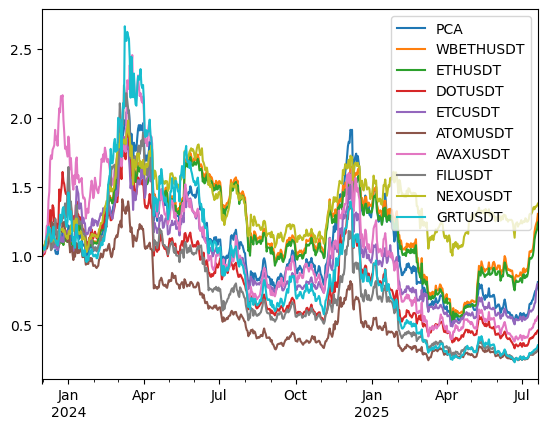

In [155]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

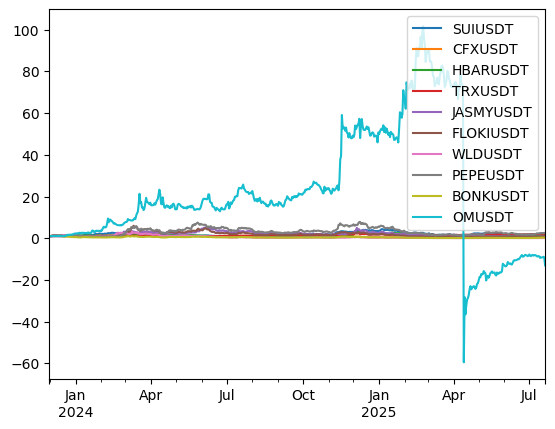

In [156]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [158]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52076995, 0.30724441, 0.06959526, 0.05993146, 0.04245893])

In [159]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049724
SOLUSDT      0.091340
ETHUSDT      0.079628
JASMYUSDT    0.138848
OMUSDT       0.254274
TRXUSDT      0.034917
BBUSDT       0.164286
BNBUSDT      0.050615
PEPEUSDT     0.135591
PAXGUSDT     0.000779
Name: PC1, dtype: float64

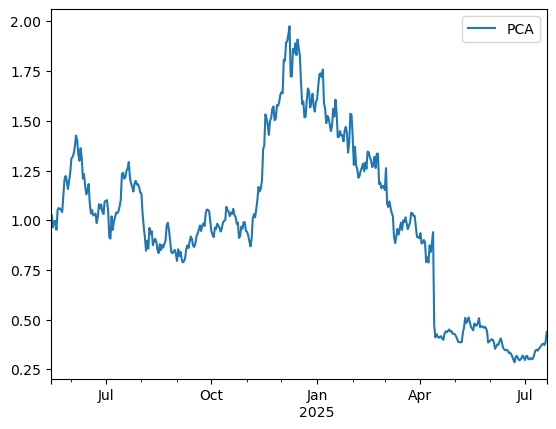

In [160]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()
plt.show()

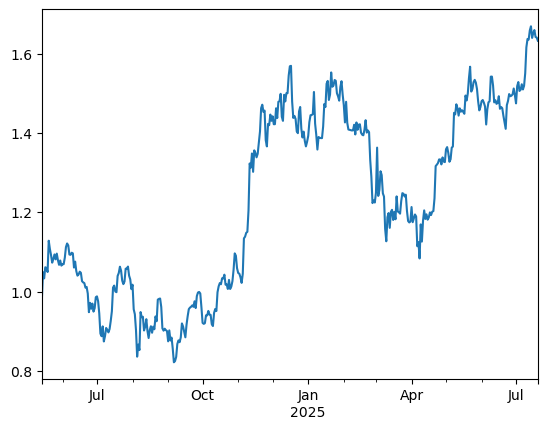

In [161]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [162]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.742592
SOLUSDT      0.779600
BTCUSDT      0.794089
BNBUSDT      0.798382
JASMYUSDT    0.989519
PEPEUSDT     1.024671
PAXGUSDT     1.047988
BBUSDT       1.052621
TRXUSDT      1.168507
dtype: float64

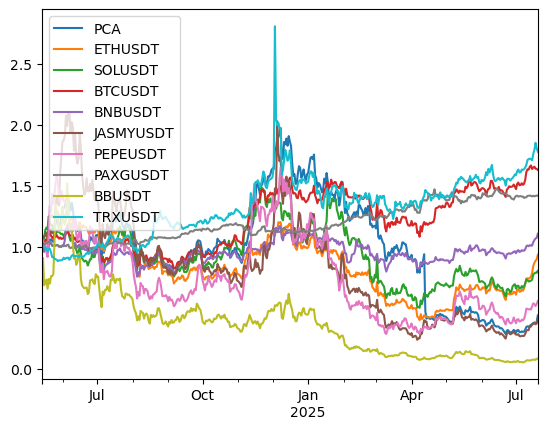

In [163]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [165]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.917427
BBUSDT       1.615950
JASMYUSDT    1.454539
SOLUSDT      1.276925
ETHUSDT      1.089058
BTCUSDT      1.000000
OMUSDT       0.984971
BNBUSDT      0.659143
TRXUSDT      0.330604
PAXGUSDT     0.027405
Name: BTCUSDT, dtype: float64

In [166]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.572316
PEPEUSDT     2.427779
JASMYUSDT    2.201964
OMUSDT       1.577390
ETHUSDT      1.476450
SOLUSDT      1.405597
BTCUSDT      1.000000
BNBUSDT      0.648851
TRXUSDT      0.537941
PAXGUSDT    -0.079859
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [168]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [169]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
ETHUSDT,0.249892
BNBUSDT,0.178799
BTCUSDT,0.173017
TRXUSDT,0.165105
JASMYUSDT,0.149536
PEPEUSDT,0.135439
BBUSDT,0.123566
OMUSDT,0.044274
SOLUSDT,0.032917
PAXGUSDT,-0.692252


### Regression to PCA

In [171]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.6492410060024358

In [172]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.394167
BNBUSDT      1.260639
PCA          1.000000
ETHUSDT      0.987753
SOLUSDT      0.772503
JASMYUSDT    0.502239
PEPEUSDT     0.493162
BBUSDT       0.441363
TRXUSDT      0.316468
PAXGUSDT     0.148962
OMUSDT       0.116630
dtype: float64

In [173]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      2.233628
BTCUSDT      1.877426
TRXUSDT      1.139473
ETHUSDT      1.052368
SOLUSDT      1.004662
PCA          1.000000
PEPEUSDT     0.679910
JASMYUSDT    0.607294
BBUSDT       0.480647
OMUSDT       0.249637
PAXGUSDT    -2.808693
dtype: float64

### Correlation Matrix

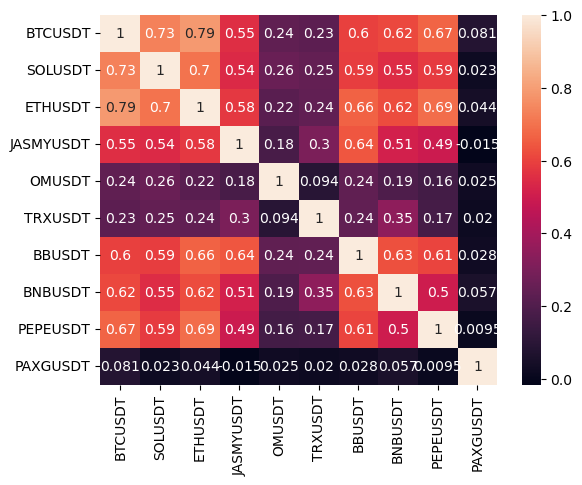

In [175]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

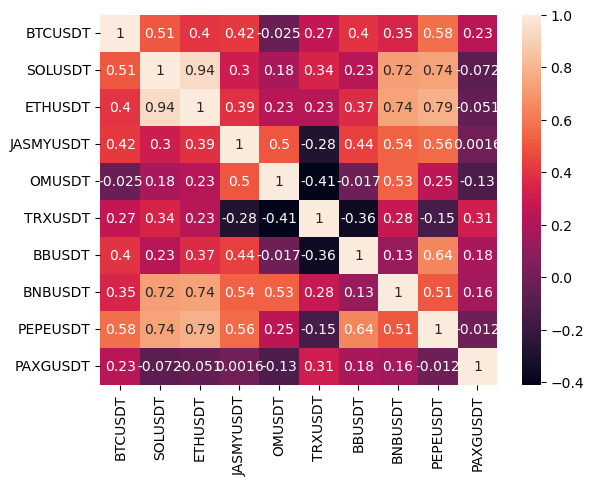

In [176]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [177]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [178]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

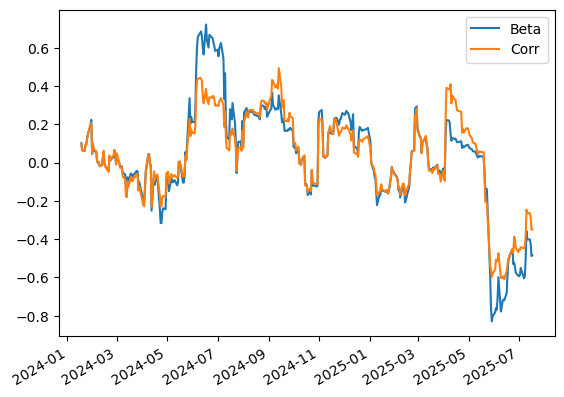

In [179]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [181]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,ETHUSDT,JASMYUSDT,OMUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.000000,0.150876,0.626168,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.019283,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453607,0.000000,0.000000,0.000000,0.546393
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.435186,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.166022,0.000000,0.176734,0.526887,0.000000,0.000000,0.130357,0.000000


In [182]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-12-12,0.166695,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.007830,0.143171,0.00000
2025-01-11,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.364471,0.00000
2025-02-10,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2025-03-12,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.074279,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2025-04-11,0.000000,0.00000,0.0,0.0,0.0,0.037537,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2025-05-11,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.103918,0.000000,0.000000,0.000000,0.00000
2025-06-10,1.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2025-07-10,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.442624,0.000000,0.084531,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2025-07-20,0.284795,0.00005,0.0,0.0,0.0,0.000000,0.000024,0.000000,0.000076,0.018631,...,0.457889,0.000015,0.0,0.0,0.000026,0.000109,0.000004,0.039322,0.038589,0.07396


In [183]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

TRXUSDT     0.457889
AAVEUSDT    0.284795
XTZUSDT     0.073960
SEIUSDT     0.056298
XLMUSDT     0.039322
XRPUSDT     0.038589
Name: 2025-07-20 00:00:00, dtype: float64

In [184]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
